In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataframes = [pd.read_csv(f"data/fitness/{d}") for d in os.listdir("data/fitness/")]
df = pd.concat(dataframes, ignore_index=True)
df.rename(lambda x: x.replace("training.", ""), axis="columns", inplace=True)
df = df[[c for c in df.columns if not c.startswith("Unnamed")]]
df["evolver"] = df["solver"] + "_" + df["ea"]
df = df[df["fitness"] != "novelty"]
df = df[df["top_k_reward.top_0_reward"] > -1000]
df.head()

,fitness_median,evaluation_time,_runtime,run_id,fitness_1q,fitness_3q,generation,fitness_mean,_timestamp,top_k_fit.top_1_fit,...,top_k_fit.top_0_fit,top_k_reward.top_1_reward,top_k_reward.top_2_reward,solver,ea,fitness,environment,seed,evaluation,evolver
0,-0.045261,32.498501,40.558031,0,0.137280,-0.245841,0,-0.166302,1.687529e+09,1.161116,...,1.206799,-100000.000000,126.580299,cgp-large,mu+lambda,distance,ant,0,0,cgp-large_mu+lambda
1,0.059202,17.230484,58.053875,0,0.221109,-0.131736,1,0.142552,1.687529e+09,1.931348,...,2.399420,-352.416534,-268.298706,cgp-large,mu+lambda,distance,ant,0,100,cgp-large_mu+lambda
2,0.187125,17.197813,75.306166,0,0.854028,-0.101398,2,0.301787,1.687529e+09,3.310228,...,7.907692,-254.286179,-72.229164,cgp-large,mu+lambda,distance,ant,0,200,cgp-large_mu+lambda
3,0.430793,17.131453,92.459941,0,1.307362,0.010996,3,0.896253,1.687529e+09,6.497297,...,14.944818,-505.204224,115.739395,cgp-large,mu+lambda,distance,ant,0,300,cgp-large_mu+lambda
4,1.553348,17.123209,109.634581,0,3.324180,0.157412,4,2.042249,1.687529e+09,8.992292,...,13.913265,43.790817,-113.579414,cgp-large,mu+lambda,distance,ant,0,400,cgp-large_mu+lambda


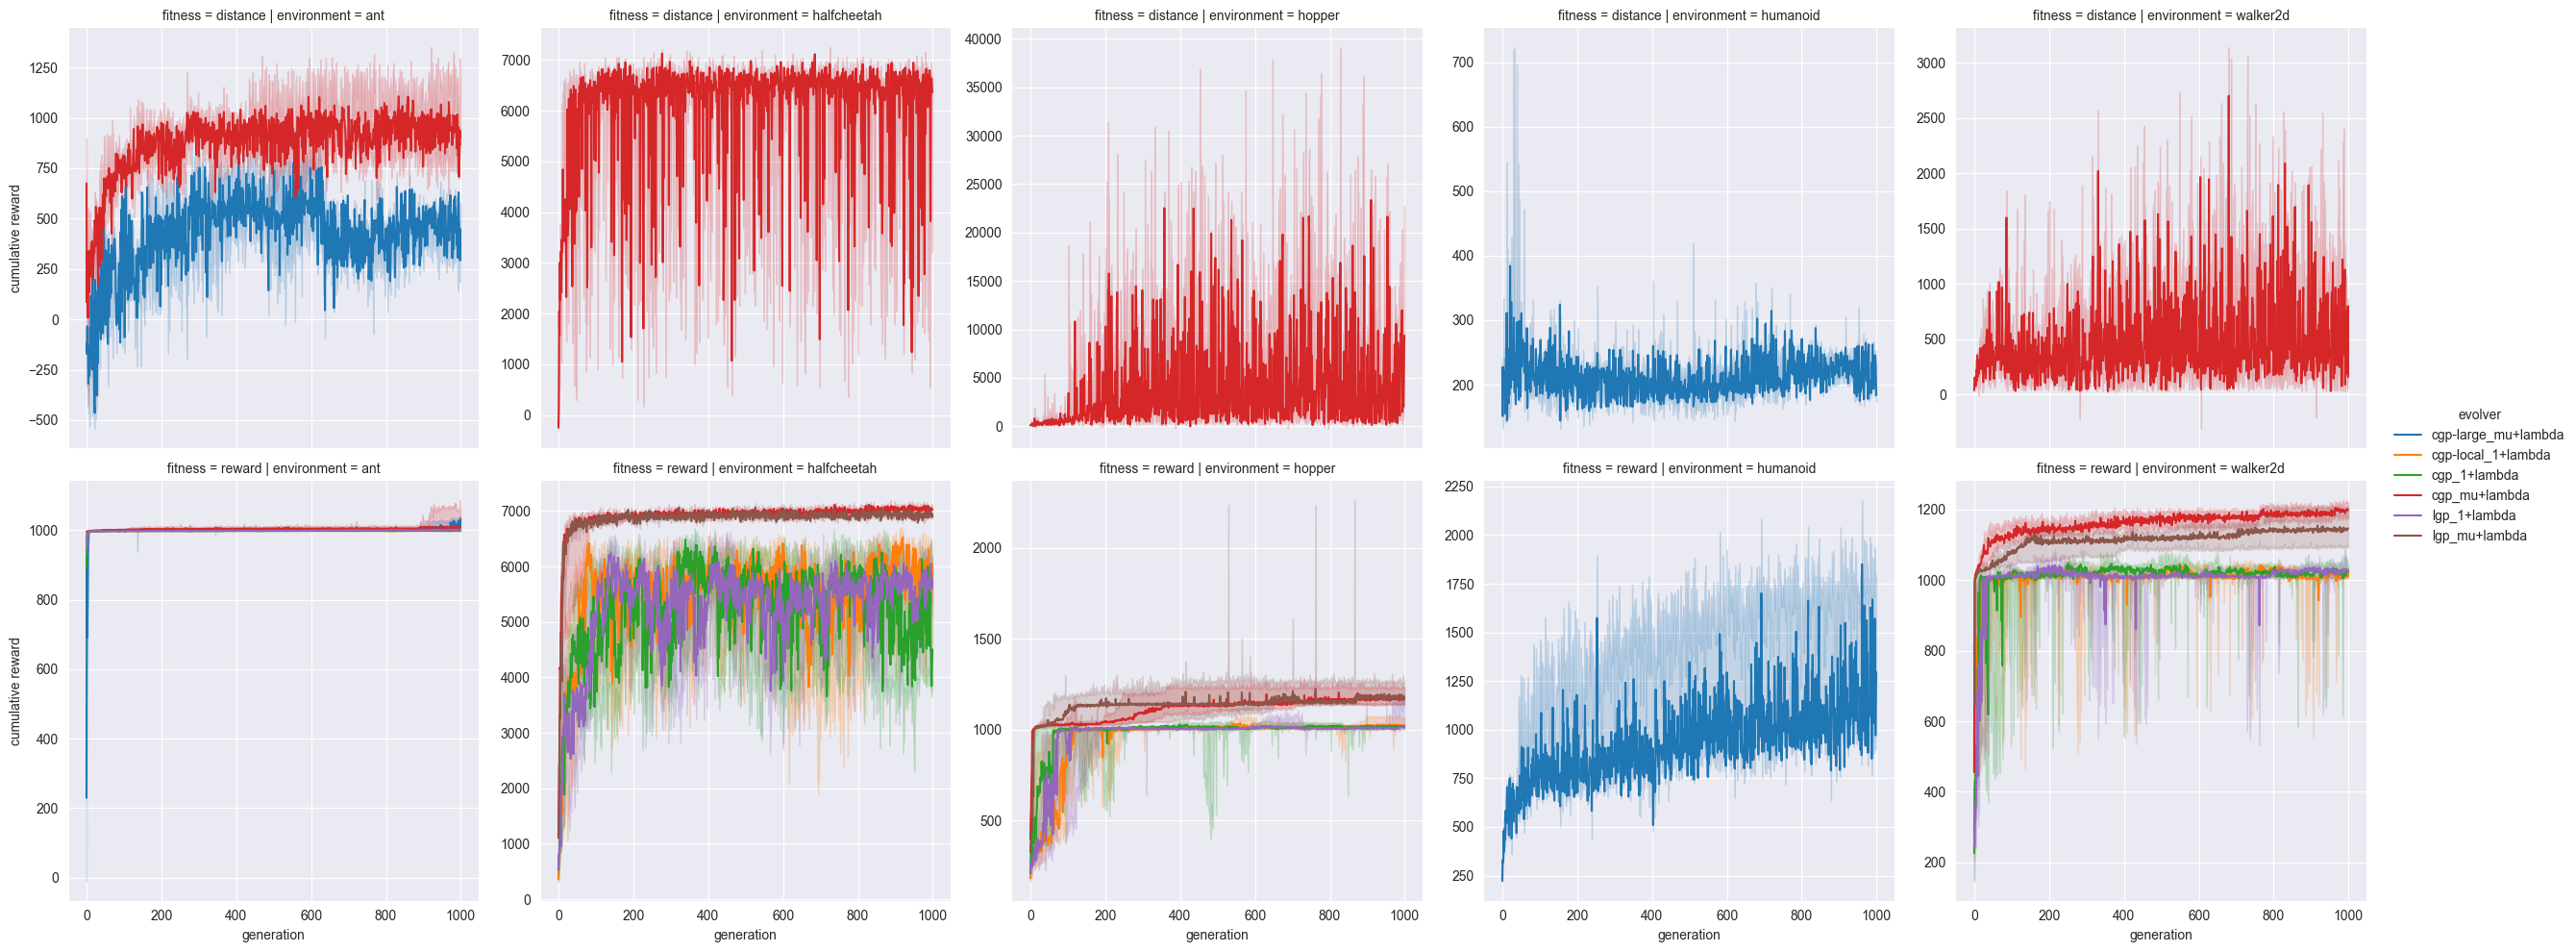

In [3]:
x_axis = "generation"
g = sns.relplot(
    data=df[(df["generation"] < 1000)] if x_axis == "generation" else df,
    col="environment",
    row="fitness",
    kind="line",
    x=x_axis,
    y="top_k_reward.top_0_reward",
    hue="evolver",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharey=False)
)
g.set_xlabels(x_axis)
g.set_ylabels("cumulative reward")
plt.show()

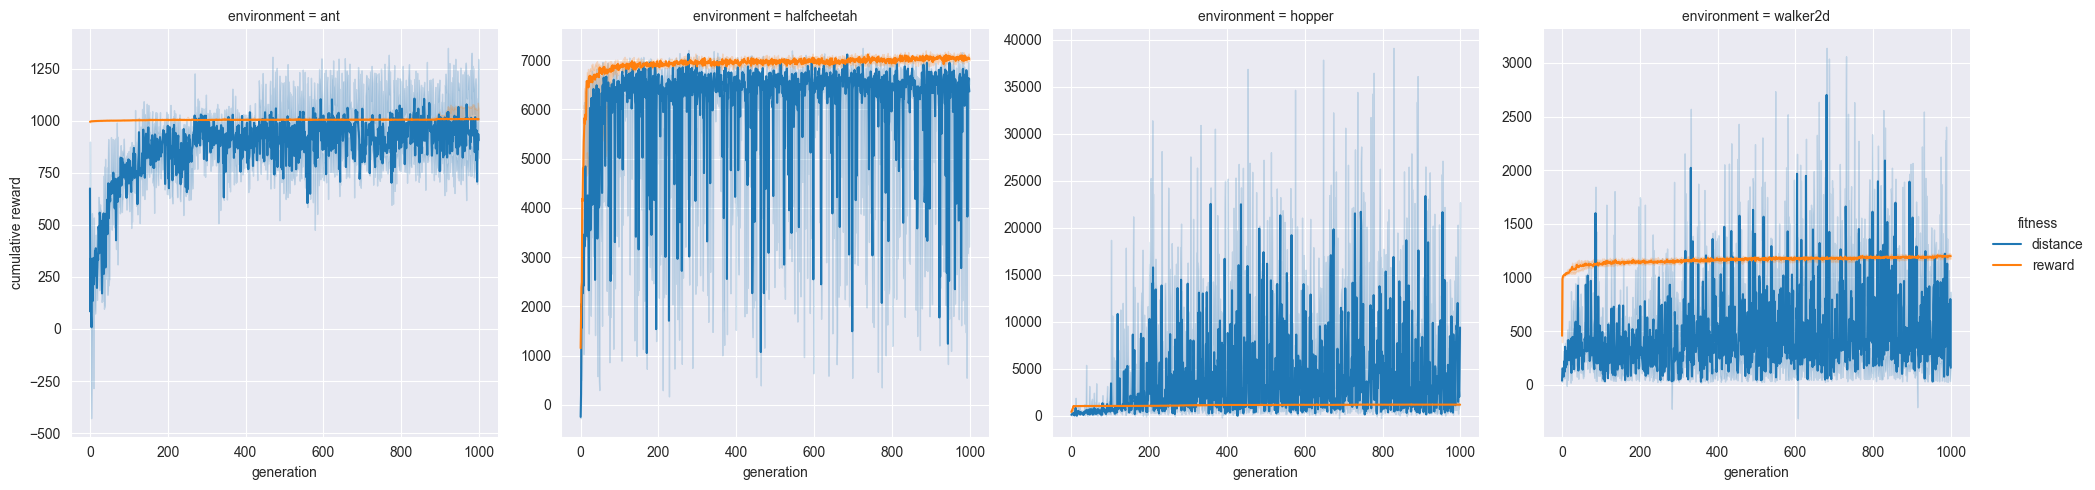

In [4]:
x_axis = "generation"
g = sns.relplot(
    data=df[(df["evolver"] == "cgp_mu+lambda")] if x_axis == "generation" else df,
    col="environment",
    kind="line",
    x=x_axis,
    y="top_k_reward.top_0_reward",
    hue="fitness",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharey=False)
)
g.set_xlabels(x_axis)
g.set_ylabels("cumulative reward")
plt.show()

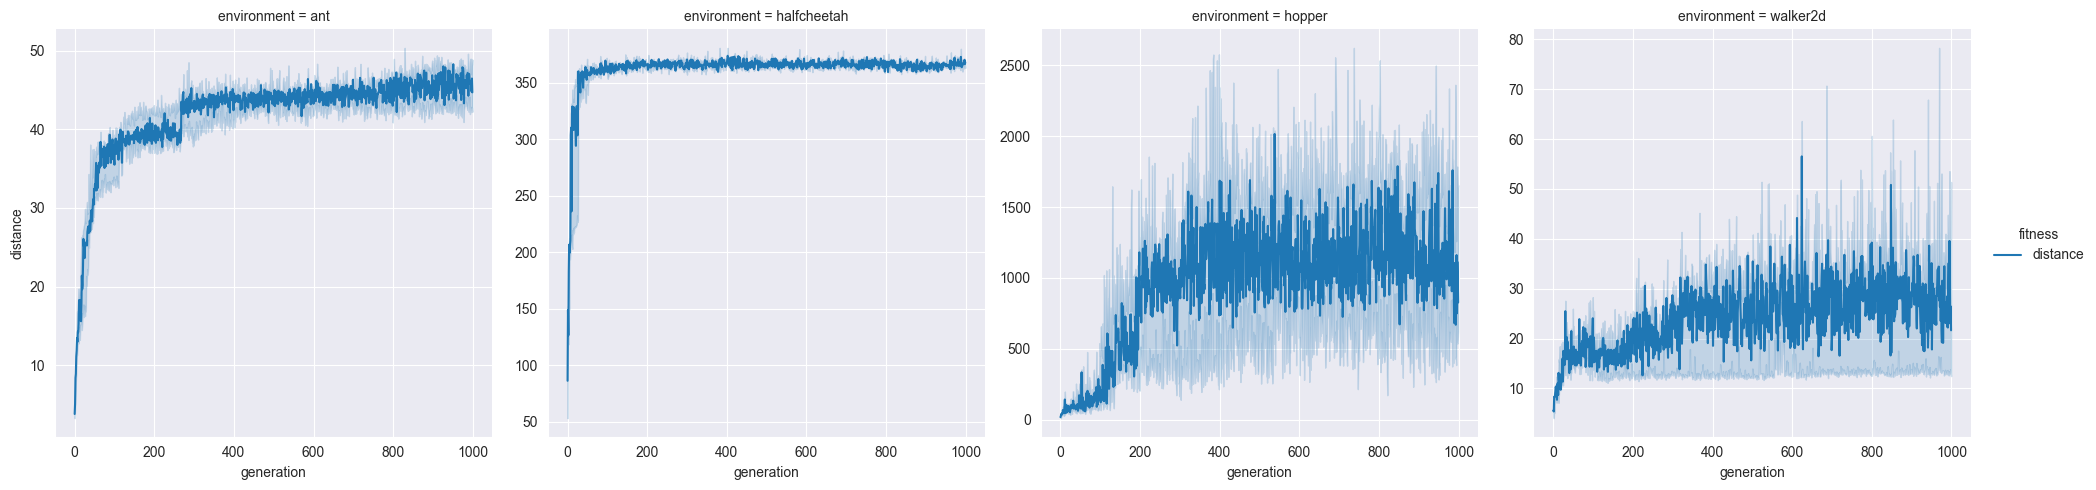

In [5]:
g = sns.relplot(
    data=df[(df["evolver"] == "cgp_mu+lambda") & (df["fitness"] == "distance")],
    col="environment",
    kind="line",
    x="generation",
    y="top_k_fit.top_0_fit",
    hue="fitness",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharey=False)
)
g.set_xlabels("generation")
g.set_ylabels("distance")
plt.show()

In [6]:
graph_dfs = [pd.read_csv(f"data/graph_size/{d}") for d in os.listdir("data/graph_size/")]
graph_sizes = pd.concat(graph_dfs, ignore_index=True)
graph_sizes["relative_size"] = graph_sizes["graph_size"] / graph_sizes["max_size"]
graph_sizes["evolver"] = graph_sizes["solver"] + "_" + graph_sizes["ea"]
graph_sizes = graph_sizes[[c for c in graph_sizes.columns if not c.startswith("Unnamed")]]
graph_sizes = graph_sizes[graph_sizes["fitness"] != "novelty"]
graph_sizes.head()

,seed,generation,evaluation,graph_size,max_size,solver,ea,fitness,environment,relative_size,evolver
0,0,599,5995995995995995995995995995995995995995995995...,101,587,cgp-large,mu+lambda,distance,ant,0.172061,cgp-large_mu+lambda
1,0,99,9999999999999999999999999999999999999999999999...,112,587,cgp-large,mu+lambda,distance,ant,0.190801,cgp-large_mu+lambda
2,0,199,1991991991991991991991991991991991991991991991...,109,587,cgp-large,mu+lambda,distance,ant,0.185690,cgp-large_mu+lambda
3,0,799,7997997997997997997997997997997997997997997997...,112,587,cgp-large,mu+lambda,distance,ant,0.190801,cgp-large_mu+lambda
4,0,399,3993993993993993993993993993993993993993993993...,116,587,cgp-large,mu+lambda,distance,ant,0.197615,cgp-large_mu+lambda


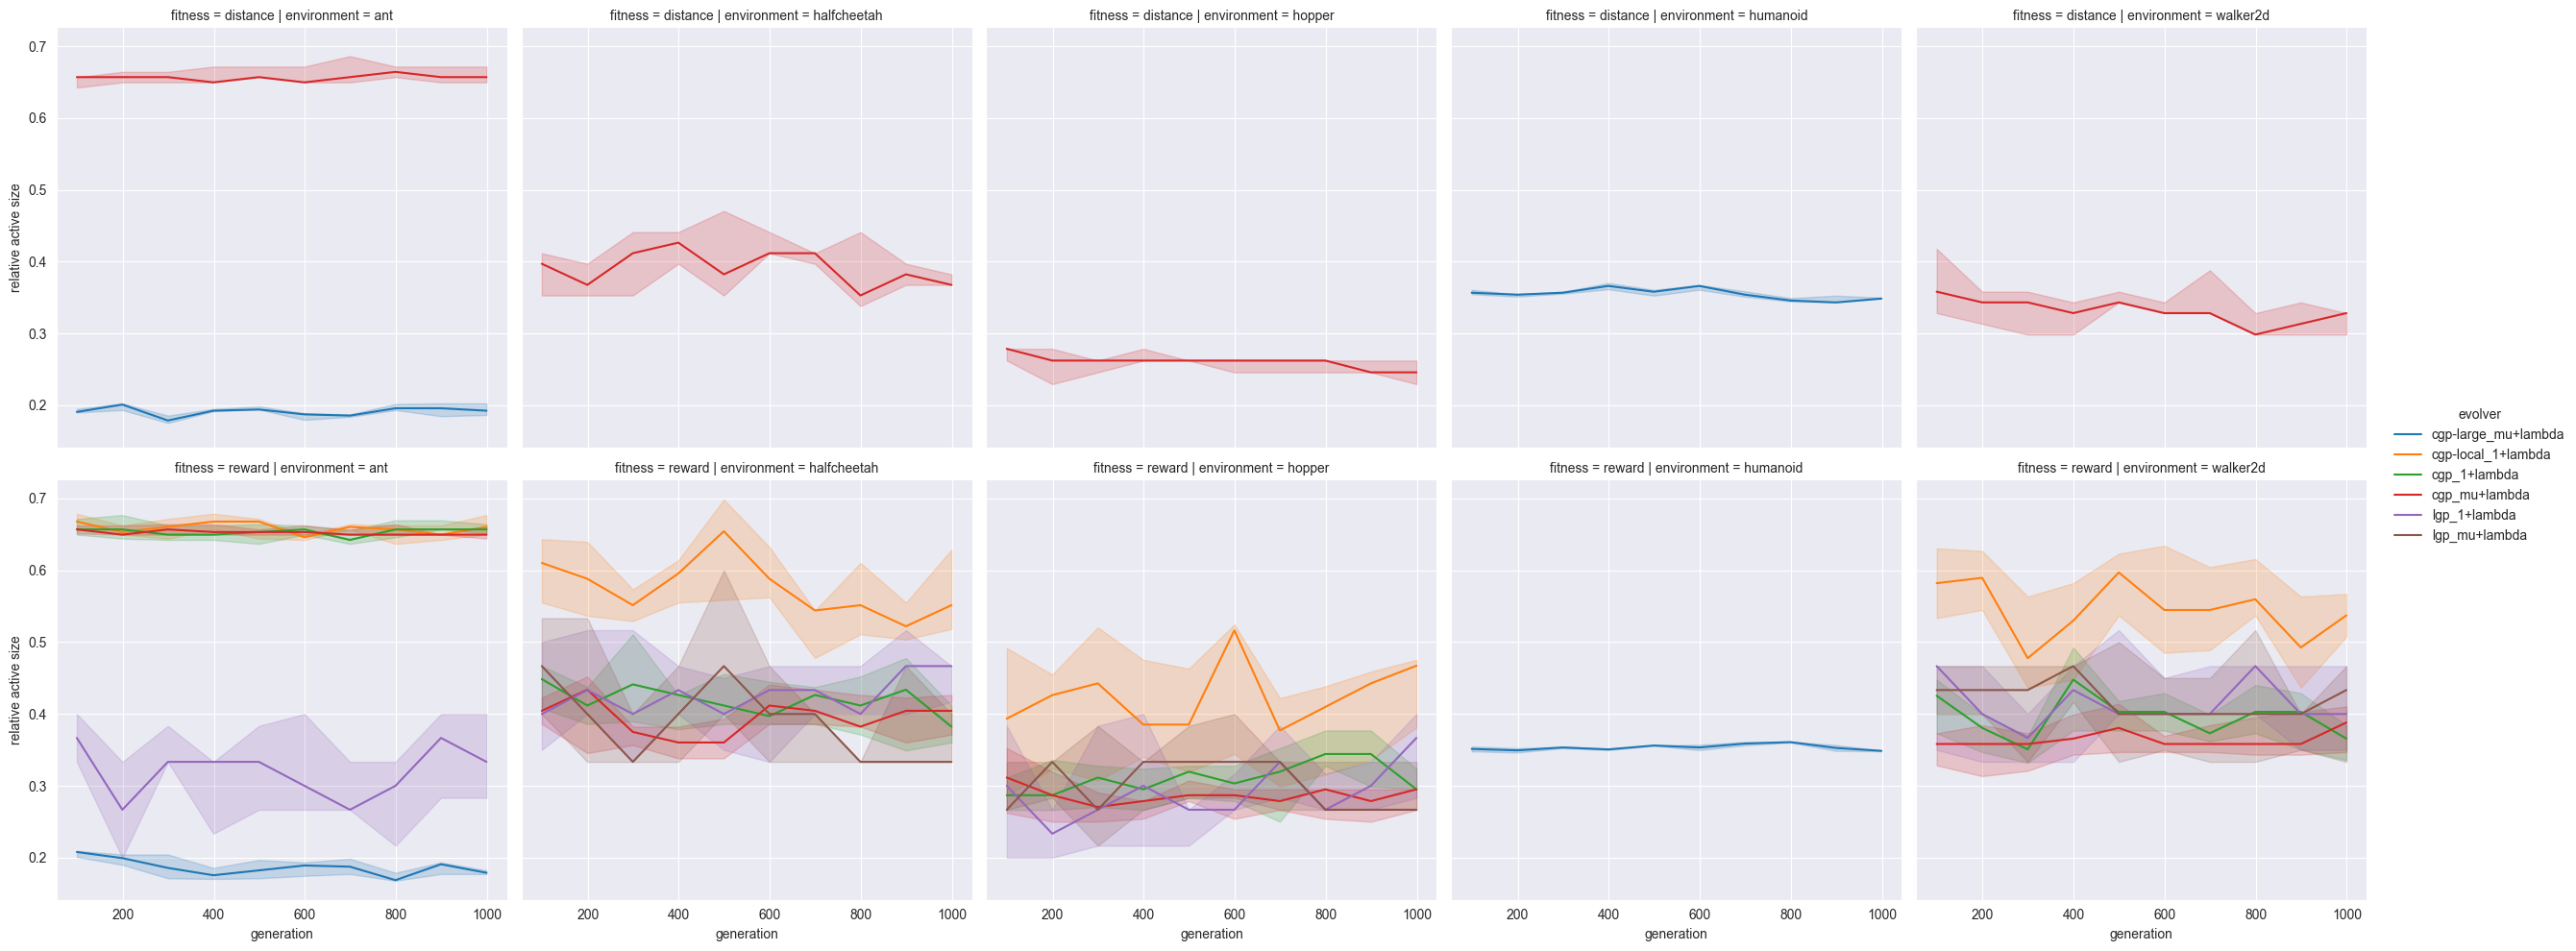

In [7]:
g = sns.relplot(
    data=graph_sizes[(graph_sizes["generation"] < 1000)],
    col="environment",
    row="fitness",
    kind="line",
    x="generation",
    y="relative_size",
    hue="evolver",
    estimator="median",
    errorbar=("pi", 50)
)
g.set_xlabels("generation")
g.set_ylabels("relative active size")
plt.show()

In [8]:
join_df = graph_sizes.merge(df, on=["solver", "generation", "environment", "seed", "evolver", "ea", "fitness"])
join_df = join_df[join_df["generation"] == 999]
join_df.head()

,seed,generation,evaluation_x,graph_size,max_size,solver,ea,fitness,environment,relative_size,...,_timestamp,top_k_fit.top_1_fit,top_k_fit.top_2_fit,top_k_reward.top_0_reward,_step,fitness_std,top_k_fit.top_0_fit,top_k_reward.top_1_reward,top_k_reward.top_2_reward,evaluation_y
8,0,999,9999999999999999999999999999999999999999999999...,106,587,cgp-large,mu+lambda,distance,ant,0.180579,...,1.687546e+09,45.332554,44.895378,710.209961,999,17.882742,47.233891,585.508972,594.886597,99900
17,1,999,9999999999999999999999999999999999999999999999...,125,587,cgp-large,mu+lambda,distance,ant,0.212947,...,1.687564e+09,41.121357,41.079456,444.416626,999,16.169733,41.441235,478.343811,466.133331,99900
29,2,999,9999999999999999999999999999999999999999999999...,113,587,cgp-large,mu+lambda,distance,ant,0.192504,...,1.687581e+09,49.271770,48.849506,446.893768,999,19.198126,49.294567,417.748230,477.994812,99900
38,0,999,9999999999999999999999999999999999999999999999...,109,587,cgp-large,mu+lambda,reward,ant,0.185690,...,1.687598e+09,1022.073120,1020.437012,1032.496704,999,10022.801758,1028.054932,996.739563,1011.088562,99900
47,1,999,9999999999999999999999999999999999999999999999...,103,587,cgp-large,mu+lambda,reward,ant,0.175468,...,1.687616e+09,1053.057495,1051.966675,1049.834106,999,347.374542,1053.320679,1048.558228,1052.002930,99900


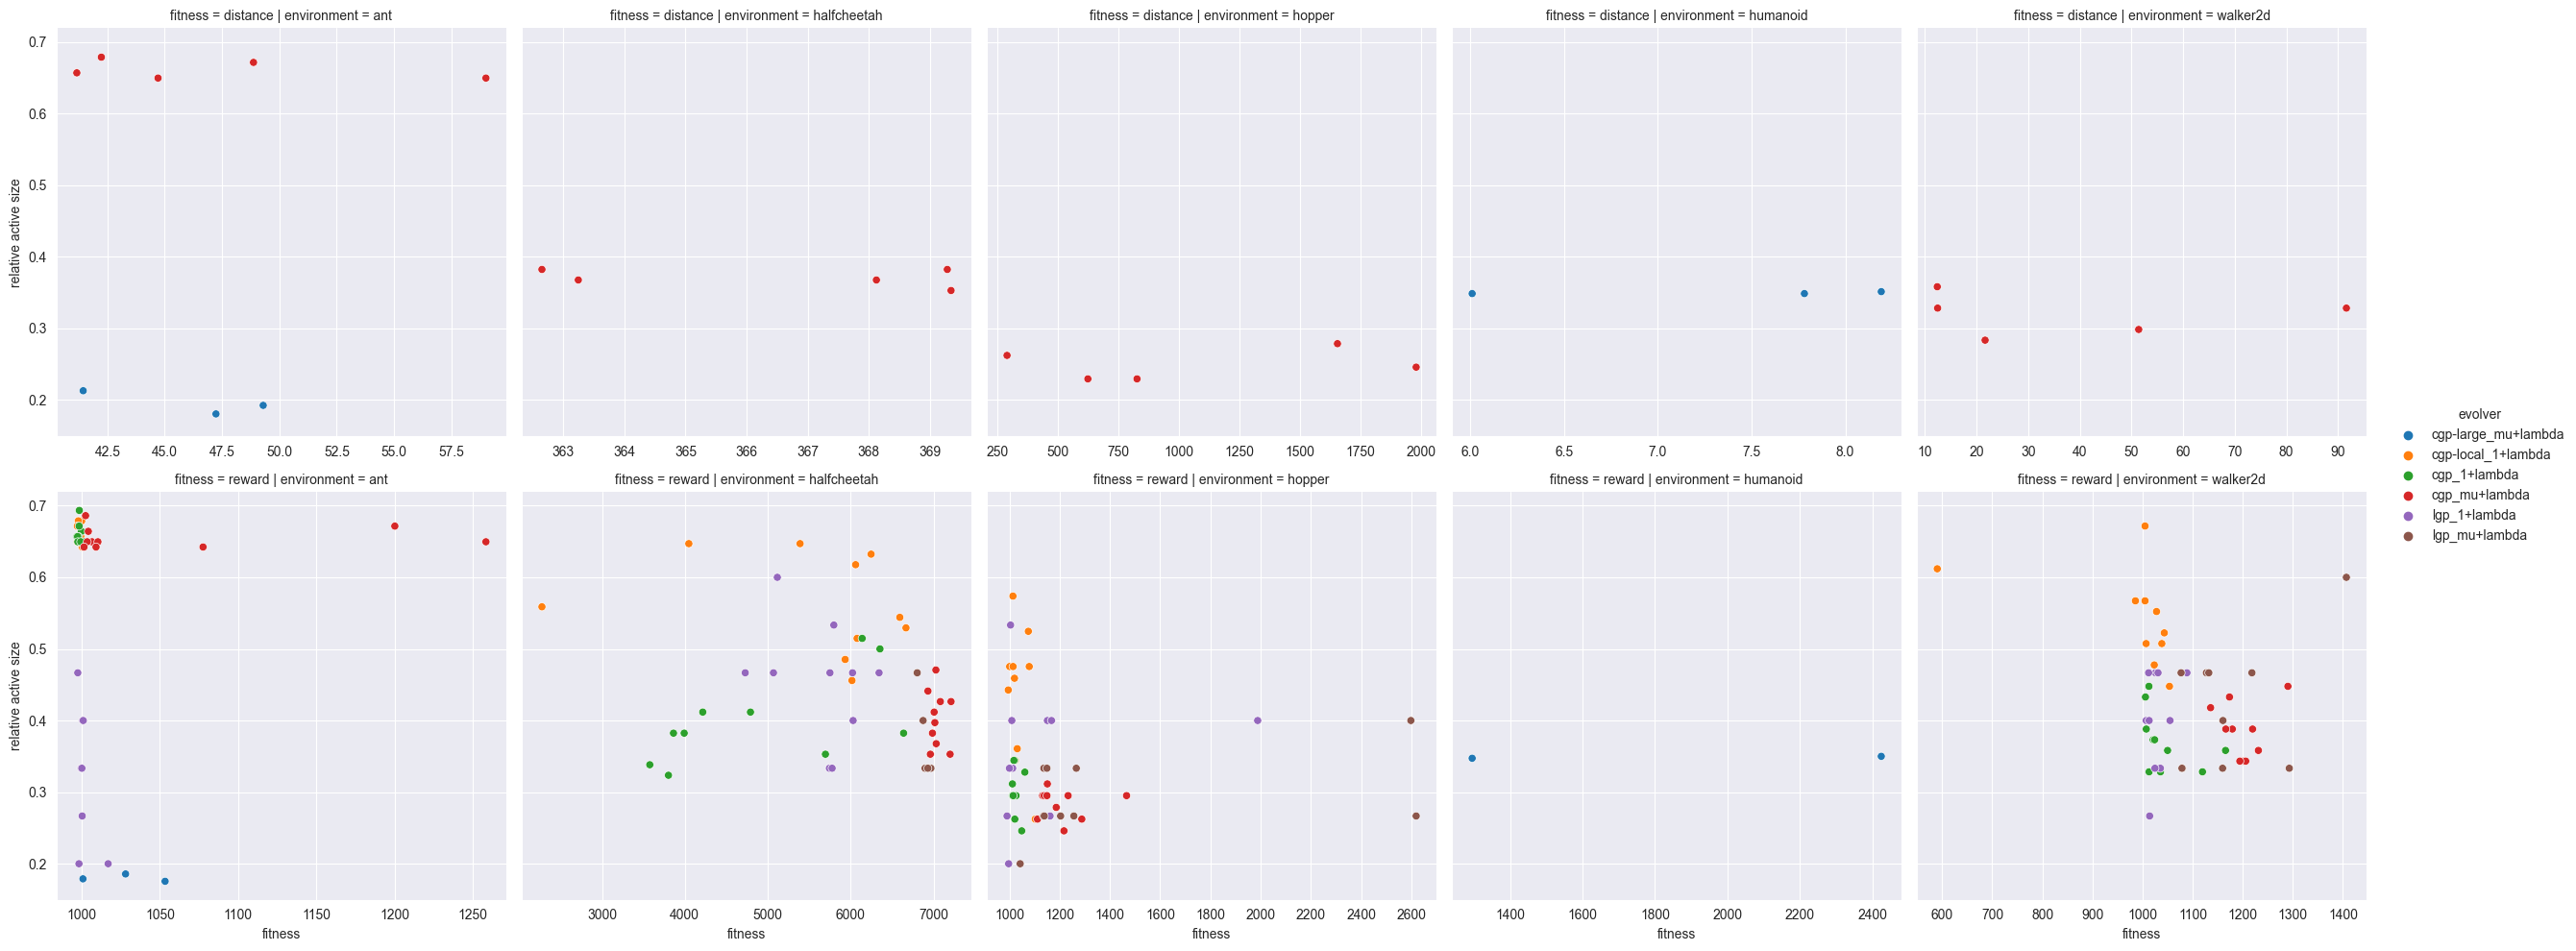

In [9]:
g = sns.relplot(
    data=join_df,
    col="environment",
    row="fitness",
    kind="scatter",
    x="top_k_fit.top_0_fit",
    y="relative_size",
    hue="evolver",
    facet_kws=dict(sharex=False)
)
g.set_xlabels("fitness")
g.set_ylabels("relative active size")
plt.show()

In [30]:
reward_dfs = []
for rew_file in os.listdir("data/rewards"):
    tmp = pd.read_csv(f"data/rewards/{rew_file}")
    env, solver, ea, fitness, seed, gen = tuple(rew_file.split("_"))
    tmp["environment"] = env
    tmp["solver"] = solver
    tmp["ea"] = ea
    tmp["fitness"] = fitness
    tmp["seed"] = seed
    tmp["generation"] = gen.replace(".csv", "")
    reward_dfs.append(tmp.reset_index().rename(columns={"index": "timestep"}))
reward_df = pd.concat(reward_dfs, ignore_index=True)
reward_df["evolver"] = reward_df["solver"] + "_" + reward_df["ea"]
reward_df = reward_df[reward_df["fitness"] != "novelty"]
reward_df.head()

,timestep,healthy,ctrl,forward,cumulative,environment,solver,ea,fitness,seed,generation,evolver
0,0,0.0,-0.840093,-0.070347,719.1954,ant,cgp-large,mu+lambda,distance,0,999,cgp-large_mu+lambda
1,1,0.0,-1.050153,-0.274541,719.1954,ant,cgp-large,mu+lambda,distance,0,999,cgp-large_mu+lambda
2,2,0.0,-1.418446,-0.387139,719.1954,ant,cgp-large,mu+lambda,distance,0,999,cgp-large_mu+lambda
3,3,0.0,-2.020024,-0.191786,719.1954,ant,cgp-large,mu+lambda,distance,0,999,cgp-large_mu+lambda
4,4,0.0,-1.859635,-0.594381,719.1954,ant,cgp-large,mu+lambda,distance,0,999,cgp-large_mu+lambda


In [31]:
reward_df = reward_df[reward_df["environment"].isin(["halfcheetah", "walker2d", "hopper"])]
reward_df = reward_df[reward_df["solver"].isin(["cgp"])]
reward_df = reward_df[reward_df["ea"] == "mu+lambda"]
reward_df = pd.melt(reward_df,
                    id_vars=["timestep", "environment", "solver", "ea", "fitness", "seed", "generation", "evolver",
                             "cumulative"],
                    value_vars=["healthy", "ctrl", "forward"])
reward_df.head()

,timestep,environment,solver,ea,fitness,seed,generation,evolver,cumulative,variable,value
0,0,halfcheetah,cgp,mu+lambda,distance,0,999,cgp_mu+lambda,6617.1943,healthy,0.0
1,1,halfcheetah,cgp,mu+lambda,distance,0,999,cgp_mu+lambda,6617.1943,healthy,0.0
2,2,halfcheetah,cgp,mu+lambda,distance,0,999,cgp_mu+lambda,6617.1943,healthy,0.0
3,3,halfcheetah,cgp,mu+lambda,distance,0,999,cgp_mu+lambda,6617.1943,healthy,0.0
4,4,halfcheetah,cgp,mu+lambda,distance,0,999,cgp_mu+lambda,6617.1943,healthy,0.0


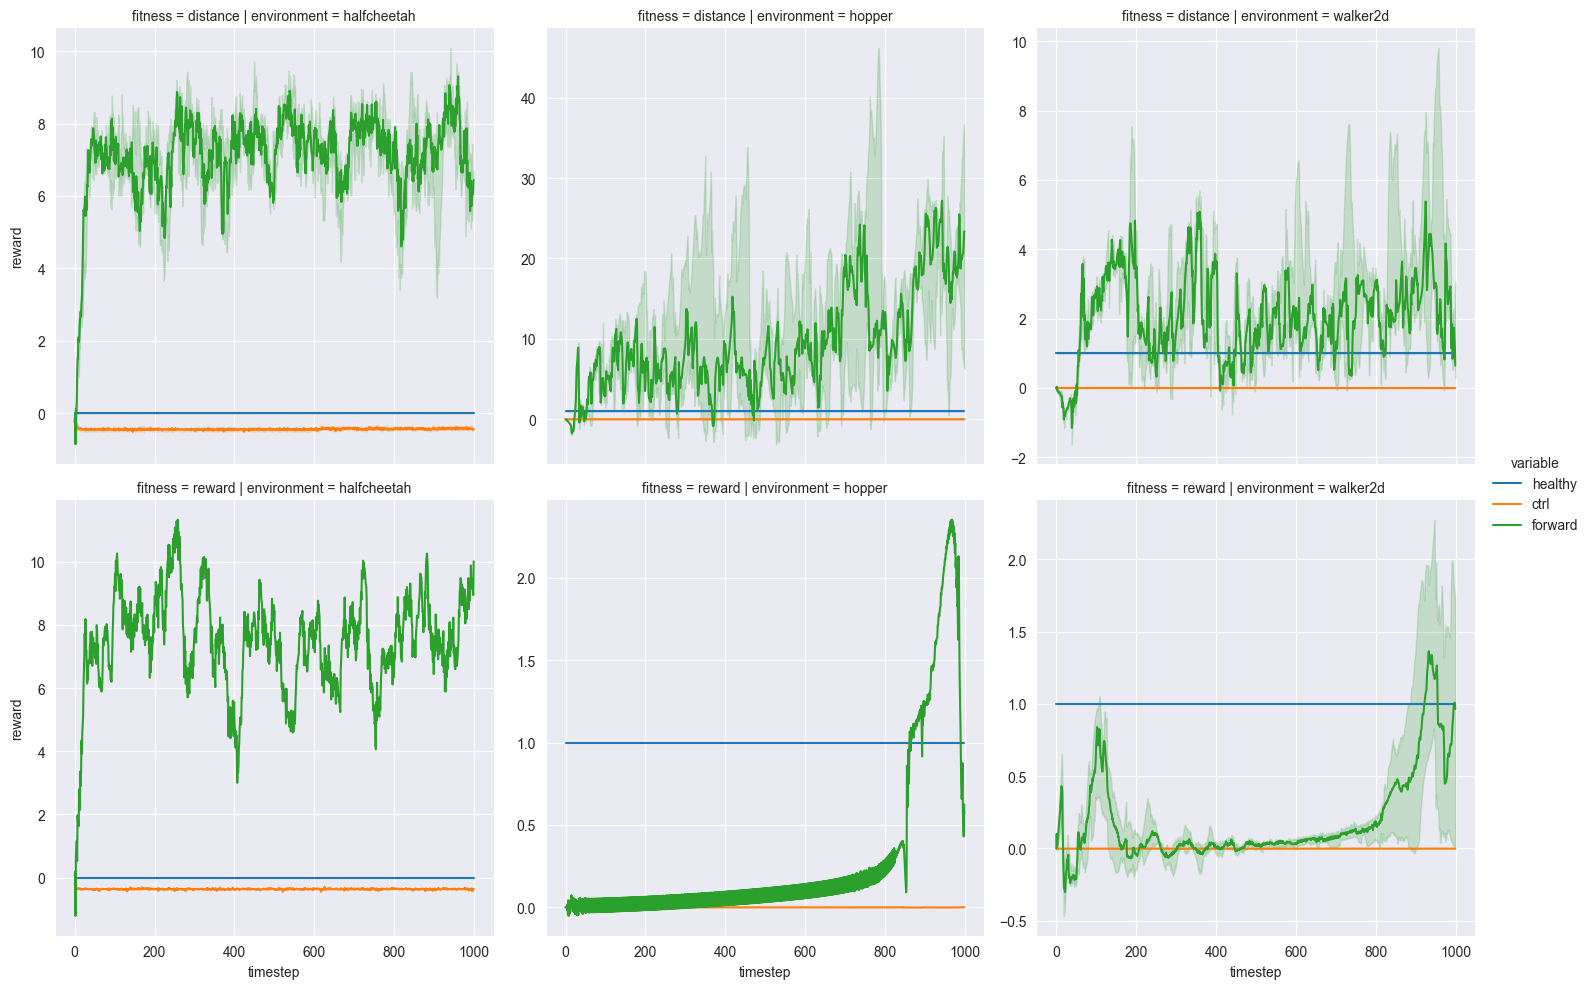

In [32]:
g = sns.relplot(
    data=reward_df,
    col="environment",
    row="fitness",
    kind="line",
    x="timestep",
    y="value",
    hue="variable",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharey=False)
)
g.set_xlabels("timestep")
g.set_ylabels("reward")
plt.show()